In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from torchvision.models import detection
import torchvision
from tqdm import tqdm, tqdm_notebook
from PIL import Image

In [16]:
class Mock():
    def __init__(self, out_size):
        self.out_size = out_size

    def eval(self):
        pass
    
    def __call__(self, x):
        return torch.ones((x.size()[0], self.out_size))

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
!unzip -q drive/MyDrive/'Colab Notebooks'/name.zip

In [55]:
def get_cropped_image(picture, coordinates, expand_coeff=2.0):
        '''
            picture: torch.Tensor
            coordinates: "indexed set" of 4 coordinates: [x1, y1, x2, y2]
        '''
        x = coordinates[0]
        y = coordinates[1]
        w = coordinates[2] - coordinates[0]
        h = coordinates[3] - coordinates[1]
        w_expanded = int(w * expand_coeff)
        h_expanded = int(h * expand_coeff)
        x_expanded = int(x - (w_expanded - w) / 2.0)
        y_expanded = int(y - (h_expanded - h) / 2.0)

        return torchvision.transforms.functional.crop(
            picture, 
            int(y_expanded), 
            int(x_expanded), 
            int(h_expanded), 
            int(w_expanded),
        )

In [56]:
class ColorDetector():
    def __init__(self, colors, THRESHOLD=1./8):
        self.THRESHOLD = THRESHOLD
        self.colors = np.array(colors)
    
    def __call__(self, image):
        image = image[0]
        h = int(self.THRESHOLD * image.shape[1])
        w = int(self.THRESHOLD * image.shape[2])
        x1 = image.shape[2] // 2 - w // 2
        y1 = image.shape[1] // 2 - h // 2
        x2 = image.shape[2] // 2 + w // 2
        y2 = image.shape[1] // 2 + h // 2
        cropped_image = get_cropped_image(image, [x1, y1, x2, y2], expand_coeff=1.0)
        plt.imshow(cropped_image.permute(1, 2, 0).detach().numpy())
        plt.show()
        color = [0] * cropped_image.shape[0]
        for channel in range(cropped_image.shape[0]):
            color[channel] = cropped_image[channel].mean().item() * 256
        color = np.array(color)
        print(color)
        return np.argmin(np.sum((self.colors - color) ** 2.0, axis=1))

In [68]:
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [69]:
# picture: torch.Tensor or np.array
# boxes: indexed object
# labels: indexed object
def draw_pic_with_rect(picture, boxes, labels, n=5):
    boxes = boxes[:n]
    labels = labels[:n]
    if isinstance(picture, torch.Tensor):
        picture = (picture.detach().squeeze(0) * 256).permute(1, 2, 0).numpy()
    picture = picture.astype(dtype=np.int)

    fig, ax = plt.subplots(figsize = (15, 15))
    ax.imshow(picture)

    for box, lab in zip(boxes, labels):
        rect = matplotlib.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                       linewidth=1, edgecolor='r', facecolor='none')
        ax.text(box[0], box[1], inst_classes[lab], fontsize = 12)
        ax.add_patch(rect)

    fig.show()

In [124]:
indices_animal_detection = [
    inst_classes.index("bird"),
    inst_classes.index("cat"),
    inst_classes.index("dog"),
    inst_classes.index("horse"),
    inst_classes.index("sheep"),
    inst_classes.index("cow"),
    inst_classes.index("elephant"),
    inst_classes.index("bear"),
    inst_classes.index("zebra"),
    inst_classes.index("giraffe"),
]

[]

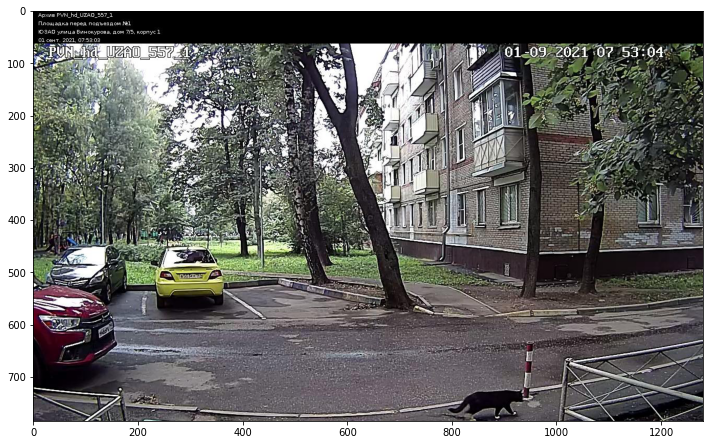

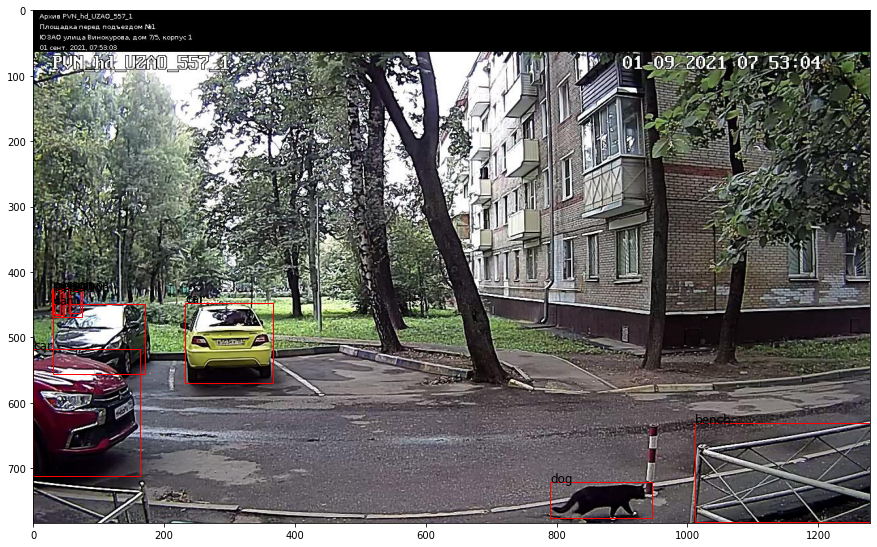

In [143]:
image = Image.open("/content/Датасет/Другие животные/201.jpg")
image_numpy = np.asarray(image)
plt.figure(figsize=(12, 10))
plt.imshow(image_numpy);
find_lost_animal.get_features(image_numpy)

[]


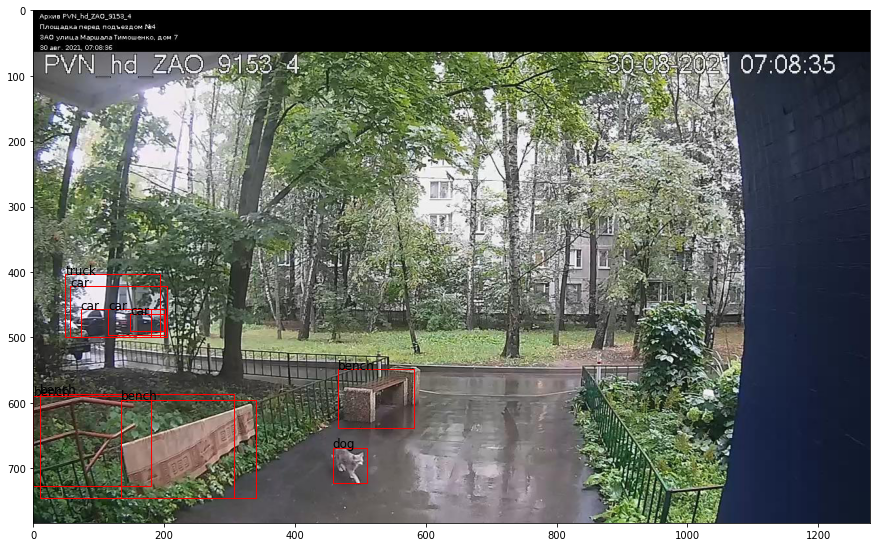

In [141]:
class FindLostAnimal():
    def __init__(self, 
                 model_detection,
                 model_classification_animal,
                 model_classification_dog_breed,
                 model_classification_dog_color,
                 model_classification_dog_tail,
                 indices_animal_detection,
                 indices_cat_dog_classification,
                 converter_dog_breed,
                 converter_dog_color,
                 converter_dog_tail,
        ):

        self.model_detection = model_detection
        self.model_classification_animal = model_classification_animal
        self.model_classification_dog_breed = model_classification_dog_breed
        self.model_classification_dog_color = model_classification_dog_color
        self.model_classification_dog_tail = model_classification_dog_tail
        self.indices_cat_dog_classification = indices_cat_dog_classification
        self.indices_animal_detection  = indices_animal_detection
        self.converter_dog_breed = converter_dog_breed
        self.converter_dog_color = converter_dog_color
        self.converter_dog_tail = converter_dog_tail

        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225],
            ),
            # torchvision.transforms.Resize((80, 80)),
        ])

        self.model_detection.eval()
        self.model_classification_animal.eval()
        self.model_classification_dog_breed.eval()
        # self.model_classification_dog_color.eval()
        self.model_classification_dog_tail.eval()


    def __get_detection_predictions(self, picture):
        pred = self.model_detection(picture)
        return pred[0]["boxes"], pred[0]["labels"]
    
    def __get_classification_animal_predictions(self, cropped_picture):
        '''
            determine class of an animal
        '''
        pred = self.model_classification_animal(cropped_picture)
        label = pred.argmax(axis=1)[0].item()
        return label

    def show_picture(self, picture):
        plt.figure(figsize=(12, 10))
        plt.imshow(picture[0].permute(1, 2, 0).detach().numpy())
        plt.show()

    def __convert_features(self, features):
        result = []
        for data in features:
            result.append(
                [
                 self.converter_dog_breed[str(data[0])],
                 self.converter_dog_color[data[1]], 
                 self.converter_dog_tail[data[2]], 
                ]
            )
        return result

    def __get_dog_features(self, dog_image):
        normalized_picture = self.transforms(dog_image)

        arr = self.model_classification_dog_breed(normalized_picture)[0].detach().numpy()
        ind = arr.argsort()[-3:][::-1]
        for breed in ind:
            print(self.converter_dog_breed[str(breed)])
        
        return [
                self.model_classification_dog_breed(normalized_picture).argmax(axis=1)[0].item(),
                self.model_classification_dog_color(dog_image), 
                self.model_classification_dog_tail(normalized_picture).argmax(axis=1)[0].item(), 
        ]
        

    def get_features(self, picture_numpy):
        features = []
        # convert picture in tensor
        picture = torch.from_numpy(picture_numpy).\
        to(dtype=torch.float32).permute(2, 0, 1) / 256
        picture.unsqueeze_(0)
        boxes, labels = self.__get_detection_predictions(picture)
        draw_pic_with_rect(picture, boxes, labels, 10)
        for box, label in zip(boxes, labels):
            # if it is an animal than we should check it
            if label in self.indices_animal_detection:
                cropped_image = get_cropped_image(picture, box, 2.0)
                pred = self.__get_classification_animal_predictions(
                    self.transforms(cropped_image)
                )
                # if it is a dog
                if pred in self.indices_cat_dog_classification:
                    self.show_picture(get_cropped_image(picture, box, 1.0))
                    features.append(self.__get_dog_features(cropped_image))
                    # cropped_image_numpy = (
                    #     get_cropped_image(picture, box, 1.0)[0].\
                    #     permute(1, 2, 0).\
                    #     detach().\
                    #     numpy() * 256
                    # ).astype(dtype=np.uint8)
                    # image = Image.fromarray(cropped_image_numpy)
                    # image.save("test.jpg")

        return self.__convert_features(features)

find_lost_animal = FindLostAnimal(
    model_detection,
    model_classification_cat_dog, 
    model_classification_dog_breed,
    ColorDetector([[0, 0, 0], [255, 255, 255]]),
    Mock(2),
    indices_animal_detection,
    [1],
    breeds_converter,
    {0: "black", 1: "white"},
    {0: "enormous"}
)


print(
    find_lost_animal.get_features(image_numpy)
)

# model_detection,
# model_classification_animal,
# model_classification_dog_breed,
# model_classification_dog_color,
# model_classification_dog_tail,
# indices_animal_detection,
# indices_cat_dog_classification,
# converter_dog_breed,
# converter_dog_color,
# converter_dog_tail,

In [94]:
breeds_converter = {"0": "Japanese_spaniel", "1": "Pekinese", "2": "Blenheim_spaniel", "3": "toy_terrier", "4": "Rhodesian_ridgeback", "5": "basset", "6": "beagle", "7": "bluetick", "8": "black-and-tan_coonhound", "9": "Walker_hound", "10": "English_foxhound", "11": "redbone", "12": "borzoi", "13": "Norwegian_elkhound", "14": "Scottish_deerhound", "15": "Weimaraner", "16": "Staffordshire_bullterrier", "17": "American_Staffordshire_terrier", "18": "Border_terrier", "19": "Irish_terrier", "20": "Norfolk_terrier", "21": "Norwich_terrier", "22": "Yorkshire_terrier", "23": "wire-haired_fox_terrier", "24": "Lakeland_terrier", "25": "Airedale", "26": "cairn", "27": "giant_schnauzer", "28": "standard_schnauzer", "29": "soft-coated_wheaten_terrier", "30": "West_Highland_white_terrier", "31": "flat-coated_retriever", "32": "golden_retriever", "33": "Labrador_retriever", "34": "Chesapeake_Bay_retriever", "35": "Irish_setter", "36": "Gordon_setter", "37": "Brittany_spaniel", "38": "Welsh_springer_spaniel", "39": "cocker_spaniel", "40": "Sussex_spaniel", "41": "Irish_water_spaniel", "42": "briard", "43": "kelpie", "44": "Shetland_sheepdog", "45": "collie", "46": "Rottweiler", "47": "Doberman", "48": "boxer", "49": "Tibetan_mastiff", "50": "malamute", "51": "Siberian_husky", "52": "pug", "53": "Leonberg", "54": "Newfoundland", "55": "Great_Pyrenees", "56": "Samoyed", "57": "Pomeranian", "58": "chow", "59": "standard_poodle", "60": "dingo"}

In [75]:
model_classification_cat_dog(torchvision.transforms.Compose([
            torchvision.transforms.Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225],
            ),
            torchvision.transforms.Resize((80, 80)),
        ])(torch.from_numpy(image_numpy).to(dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)))

tensor([[ 1.8643, 14.3293]], grad_fn=<AddmmBackward>)

In [93]:
model_classification_dog_breed_fp = torchvision.\
models.resnet50(pretrained = True)

n_inputs = 1000
n_classes = 61
model_classification_dog_breed_sp = nn.Sequential(
                      nn.Linear(n_inputs, 512),
                      nn.Tanh(),
                      nn.Dropout(0.3),
                      nn.Linear(512, 256),
                      nn.ReLU(),
                      nn.Linear(256, n_classes)
                      )
model_classification_dog_breed_sp.load_state_dict(
    torch.load('/content/model_classification_dog_breeds.pt', map_location=torch.device('cpu'))
    )

model_classification_dog_breed = nn.Sequential(model_classification_dog_breed_fp, 
                                             model_classification_dog_breed_sp)

In [42]:

# import torch.nn as nn
# n_inputs = 1000
# n_classes = 6
# torch.manual_seed(42)
# model_classification_dog_breed_sp = nn.Sequential(
#                       nn.Linear(n_inputs, 256), 
#                       nn.ReLU(), 
#                       nn.Dropout(0.4),
#                       nn.Linear(256, n_classes),
#                       )


# model_classification_dog_breed_sp.load_state_dict(torch.load(''))

# # model_classification_dog_breed_sp = torchvision.

In [41]:
model_classification_cat_dog_fp = torchvision.\
models.resnet34(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [45]:
import torch.nn as nn
n_inputs = 1000
n_classes = 2
torch.manual_seed(42)
model_classification_cat_dog_sp = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),
                      )


model_classification_cat_dog_sp.load_state_dict(
    torch.load('/content/linear_model_cat_dogs_bq.pt', map_location=torch.device('cpu'))
    )


<All keys matched successfully>

In [73]:
model_classification_cat_dog = nn.Sequential(model_classification_cat_dog_fp, 
                                             model_classification_cat_dog_sp)

In [4]:
model_detection = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained = True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]